<a href="https://colab.research.google.com/github/Jihyun13579/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch5_4_pg_303~310_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이썬 머신러닝 완벽가이드 ch5. 4 pg. 303~310 필사

**2129014 박지현**

**2023.05.21**

## CH05.04. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

사이킷런의 linear_models 모듈에서 제공하는 다양한 종류의 선형 기반 회귀 클래스 중 규제가 적용되지 않은 선형 회귀를 사이킷런에서 구현한 클래스인 **LinearRegression**을 이용해 보스턴 주택 가격 예측 회귀 구현하기

### LinearRegression 클래스 - Ordinary Least Squares

**LinearRegression 클래스**
: 예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares) 추정 방식으로 규현한 클래스

- fit() 메서드 : X,y 배열 입력 시 회귀 계수(Coefficients)인 W를 coef_ 속성에 저장함

- OLS 기반 회귀 계수 계산 : 입력 피처의 독립성에 많은 영향 
 - **다중공선성(multi-collinearity)**: 상관관계가 매우 높은 경우 분산 증가 > 오류에 매우 민감해짐
 - 다중공선성의 문제 해결 : 독립적인 중요 피처만을 남기고 제거 OR 규제 적용 OR PCA를 통해 차원 축소 수행(매우 많은 피처가 다중 공선성 문제일 경우)

 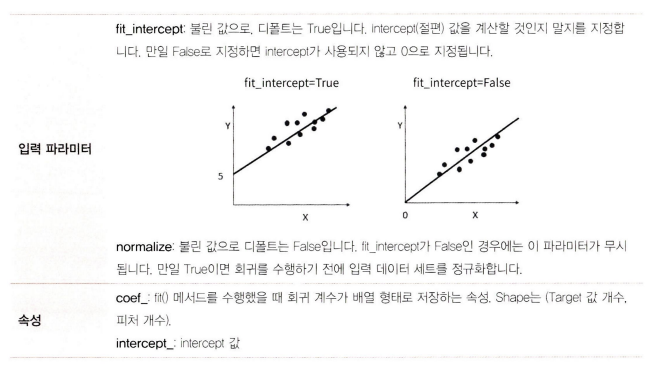


In [4]:
# class sklearn.linear_model.LinearRegression(fit_intercept = True, normalize=False, copy_X = True, n_jobs=1)

### 회귀 평가 지표

회귀의 평가를 위한 지표 : 실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심

- 그냥 더할 시 차이의 +, - 가 섞여 오류가 상쇄됨 > **오류의 절댓값 평균이나 제곱, or 제곱한 뒤 다시 루트를 씌운 평균값**으로 평가함

- 회귀 성능 평가 지표의 종류

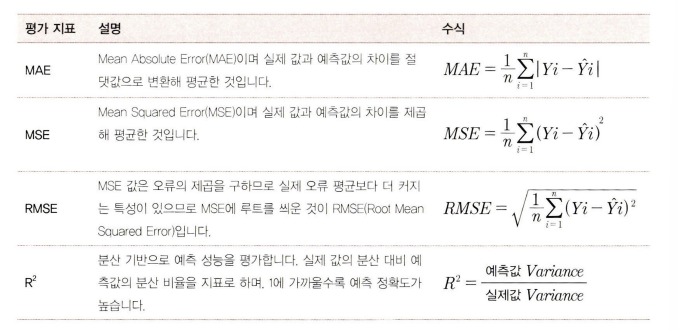

   - MSLE(Mean Squared Log Error) : MSE에 로그 적용
   - RMSLE(Root MEan Squared Log Error) : RMSE에 적용

**사이킷런에서의 회귀 평가 지표**

|평가 방법|사이킷런 평가 지표 API|Scoring 함수 적용 값|
|-----|-----|-----|
|MAE|metrics.mean_absolute_error|'neg_mean_absolute_error'|
|MSE|metrics.mean_squared_error|'neg_mean_squared_error'|
|RMSE|사이킷런에서 제공 X > MSE에 제곱근 씌우기|.|
|R^2|metrics.r2_score|'r2'|

- Scoring 함수(ex. cross_val_score, GridSearchCV...)에 회귀 평가 지표 적용 시 유의점 : 'scoring'값의 'neg_' = 음수값을 반환하게 함 
 - WHY -1 곱해서 음수 값으로 보정? : Scoring 함수가 score 값이 클수록 좋은 평가 결과로 자동 평가하기 때문, But 회귀 평가 지표: 실제 값과 예측 오류 차이 기반 > 값이 커지면 나쁜 모델이라는 의미 >> 값이 작을수록 더 좋은 평가 지표로 인식하게 함
 - 사이킷런 평가 지표 API(ex. metrics.mean_absolute_error()): 정상적으로 양수의 값 반환함

### LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

LinearRegression 클래스를 이용해 선형 회귀 모델 생성하기
 - 사이킷런에 내장된 데이터 세트: 보스턴 주택 가격 데이터 이용하기
 -해당 데이터셋의 피처와 피처에 대한 설명
 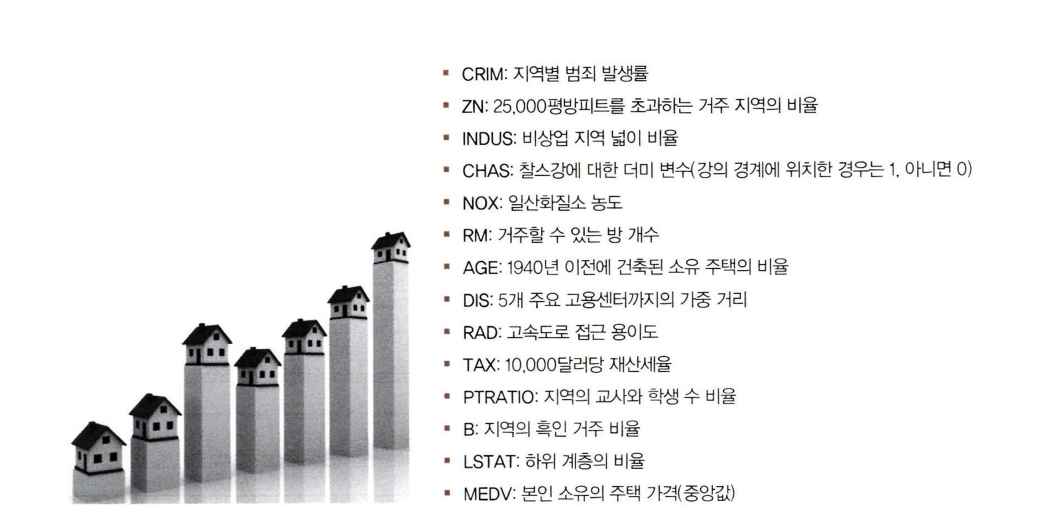

- 해당 데이터 세트(load_boston())를 로드하고 DataFrame으로 변경하기

In [6]:
from ast import increment_lineno
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
#from sklearn.datasets import load_boston   #현재는 사용 불가 > 피처 중 '흑인' 비율 존재 > 시대착오적!
%matplotlib inline

# boston 데이터 세트 로드
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston, columns=['CRIM','ZN','INDUS','CHAS', 'NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = pd.DataFrame(target, columns=['MEDV'])
print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- 데이터 세트 피처 : 모두 Null 값 X, 모두 float형

In [7]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


- 각 칼럼이 회귀 결과에 미치는 영향이 어느 정도인지 시각화해서 알아보기
 - ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD'] 8개의 칼럼에 대해 값이 증가할수록 'PRICE'값이 어떻게 변하는지 확인하기

- seaborn의 'regplot()' API : X, Y 축 값의 산점도와 함께 선형 회귀 직선 그려주는 메서드

- matplotlib의 'subplots(figsize=, ncols=(열 방향으로 위치할 그래프의 개수), nrows=(행 방향으로 위치할 그래프의 개수))' : 여러 개의 그래프를 한번에 표현하기 위해 자주 사용

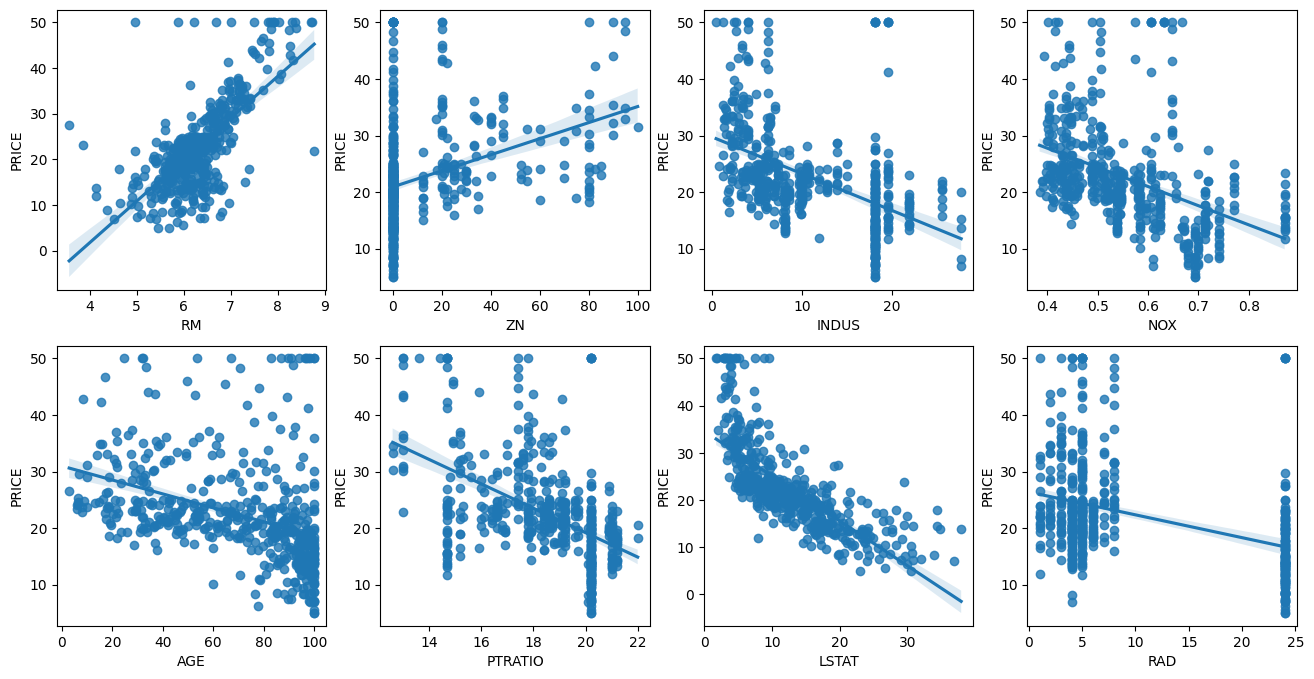

In [8]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4*2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD'] 
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

> 결과
 - 다른 칼럼보다 'RM', 'LSTAT'의 price 영향도가 가장 두드러지게 나타남
 - RM(방 개수) : 양 방향의 선형성(Positive Linearity)이 가장 큼
 - LSTAT(하위 계층의 비율) : 음 방향의 선형성(Negative Linearity)이 가장 큼

- LinearRegression 클래스를 이용해 보스턴 주택 가격의 회귀 모델 만들기
 - train_test_split() 이용 : 학습과 테스트 데이터 세트 분리해 학습/예측 수행
 - metrics 모듈의 mean_squared_error() & r2_score() API 이용해 MSE & R2 Score 측

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3,
                                                    random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


- LinearRegression으로 생성한 주택가격 모델의 intercept(절편)rhk coefficients(회귀 계수) 값 보기

In [12]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164826
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


- coef_ 속성을 피처별 회귀 계수 값으로 다시 매핑 후, 높은 값 순으로 출력하기

In [13]:
# 판다스 Series의 sort_values() 함수 이용
#회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

> 결과 : RM > 양의 값으로 회귀 계수 가장 큼 / NOX > 회귀 계수 - 값이 매우 큼

- 5개의 폴드 세트에서 cross_val_score() 이용해 교차검증으로 MSE&RMSE 측정하기
 - 사이킷런의 cross_val_score() 이용 : RMSE 제공 X > MSE 수치 결과를 RMSE로 변환 필요((평가 지표 'neg_mean_squared_error'인 cross_val_score()에서 반환된 값)*-1 에 넘파이의 sqrt() 함수 적용)
 - 회귀의 평가 지표 MSE & RMSE : 낮을 수록 좋은 회귀 모델 > 사이킷런의 지표 평가 기준인 '높은 지표 값일수록 좋은 모델'에 맞추기 위해 -1을 곱해 음수로 반환('neg_mean_squared_error')
 -cross_val_score(scoring='neg_mean_squared_error')로 반환된 값: 모두 음수

In [14]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829
